#　Python  決定木 vs LightGBM     精度差を徹底比較してみた

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import lightgbm as lgb



#=============================================
# 1. データ読み込む
#=============================================
df = pd.read_csv("文字_sample_car_data_数値.csv", encoding='shift-JIS')
#df_moto = pd.DataFrame(df_moto)
df.head(3)

In [16]:

#=============================================
# データ読み込む
#=============================================
#CSVファイル(sample_car_data.csv)をShift-JISエンコードで読み込みます。
df_moto = pd.read_csv("文字_sample_car_data_数値.csv", encoding='shift-JIS')
# データの先頭3行を表示して、読み込み結果を確認します
df_moto.head(3)

,customer_id,family,age,gender,income,marital_status,children,region,employment_type,hobby,car_preference,previous_car_owner,previous_manufacturer,manufacturer
0,1,3,31,0,828,1,0,0,2,1,2,1,6,5
1,2,3,46,0,482,1,0,1,0,3,1,1,6,6
2,3,1,51,0,718,0,0,2,0,4,2,0,99,6


In [17]:
#=============================================
# カテゴリ列のデータをカテゴリ型に変換する
#=============================================
# 数値として扱いたい列（連続値など）
numeric_cols = ["family", "age","children", "income"]

# IDや目的変数は変換対象から除外
exclude_cols = ["customer_id", "manufacturer"]

# 変換対象のカテゴリ列を抽出
categorical_cols = [
    col for col in df_moto.columns
    if col not in exclude_cols + numeric_cols
]

# カテゴリ型にする
df_moto[categorical_cols] = df_moto[categorical_cols].astype("category")


In [18]:
#=============================================
# 説明変数（特徴量）を設定
#=============================================
# 顧客IDと目的変数の「manufacturer」は除外
X_df = df_moto.drop(['customer_id', 'manufacturer'], axis=1)

#=============================================
# 目的変数を設定
#=============================================
y_df = df_moto['manufacturer']

# クラス数（カテゴリーの種類）を確認
classes = np.unique(y_df)
print("クラス:", classes)

#=============================================
# データ分割
#=============================================
# 説明変数(X_df)と目的変数(y_df)を訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=0)

print("訓練データ数:", len(X_train))
print("テストデータ数:", len(X_test))


クラス: [0 1 2 3 4 5 6]
訓練データ数: 300
テストデータ数: 100


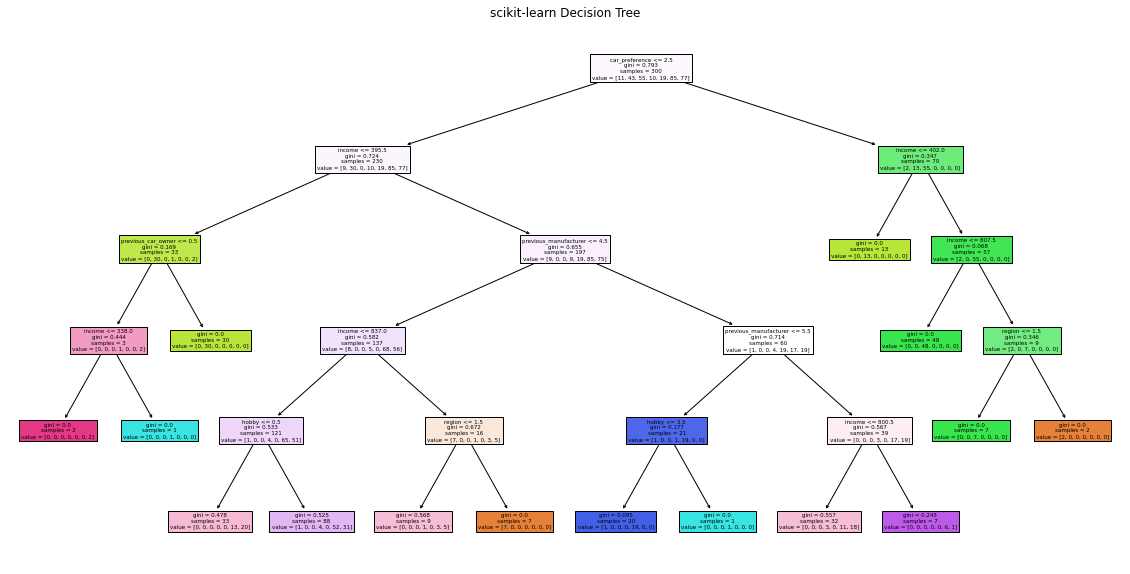

In [19]:
#=============================================
# 決定木モデルの作成・学習
#=============================================
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
# テストデータに対する予測
y_pred_dt = dt_model.predict(X_test)

#=============================================
# 決定木の可視化 (scikit-learn)
#=============================================
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X_df.columns)
plt.title("scikit-learn Decision Tree")
plt.savefig("比較用_Tree.png", dpi=300)
plt.show()


In [20]:

#=============================================
# LightGBM：目的に応じて設定
#=============================================
if len(classes) == 2:
    objective = 'binary'
    metric = 'binary_error'
else:
    objective = 'multiclass'
    metric = 'multi_error'

params = {
    'objective': objective,
    'metric': metric,
    'verbose': -1,
}
if objective == 'multiclass':
    params['num_class'] = len(classes)
    
    
#=============================================
# LightGBM用データセットを作成（特徴量名を指定）
#=============================================
lgb_train = lgb.Dataset(
    X_train.values,
    label=y_train.values,
    feature_name=X_df.columns.tolist()
)
# モデル学習（50回のブースティング）
lgb_model = lgb.train(params, lgb_train, num_boost_round=50)

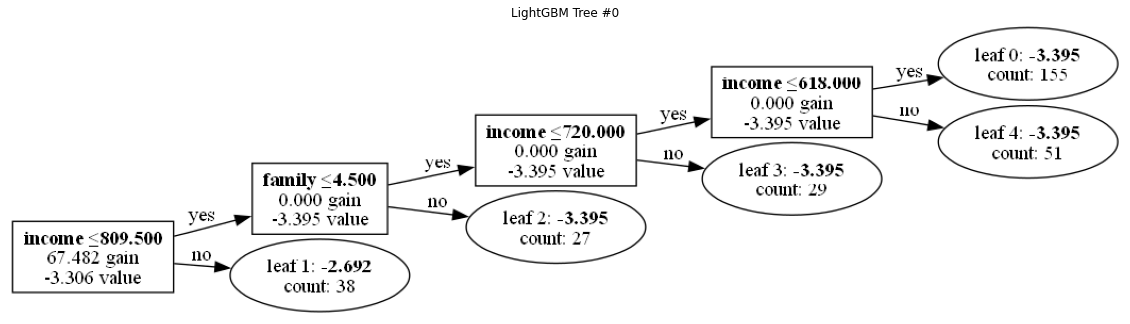

In [21]:
#=============================================
# テストデータで予測
#=============================================
y_pred_lgb_prob = lgb_model.predict(X_test.values)
# クラス予測（確率→ラベル）
if objective == 'binary':
    y_pred_lgb = (y_pred_lgb_prob > 0.5).astype(int)
else:
    y_pred_lgb = np.argmax(y_pred_lgb_prob, axis=1)

#=============================================
# LightGBMの木の構造 (特徴量名表示)
#=============================================
ax = lgb.plot_tree(
    lgb_model,
    tree_index=0,        # 表示する木の番号（0番目の木）
    figsize=(20, 10),    # 図のサイズ指定
    show_info=['split_gain', 'internal_value', 'leaf_count']
)
plt.title("LightGBM Tree #0")
plt.savefig("LightGBM_Tree.png", dpi=300)
plt.show()


【DecisionTree】 Accuracy: 0.72
【DecisionTree】 F1 Score: 0.719026507154586
【LightGBM】     Accuracy: 0.69
【LightGBM】     F1 Score: 0.6915874168179069


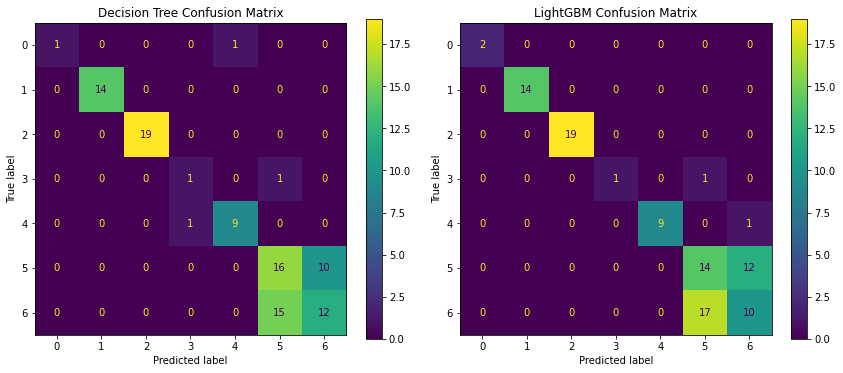

In [22]:

#=============================================
# 精度評価
#=============================================
print("【DecisionTree】 Accuracy:", accuracy_score(y_test, y_pred_dt))
print("【DecisionTree】 F1 Score:", f1_score(y_test, y_pred_dt, average='weighted'))

print("【LightGBM】     Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("【LightGBM】     F1 Score:", f1_score(y_test, y_pred_lgb, average='weighted'))

#=============================================
# 混同行列の表示
#=============================================
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# 決定木の混同行列
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, ax=ax[0])
ax[0].set_title("Decision Tree Confusion Matrix")
# LightGBMの混同行列
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgb, ax=ax[1])
ax[1].set_title("LightGBM Confusion Matrix")

plt.tight_layout()
plt.show()